# 7m data 

![](https://www.kth.se/polopoly_fs/1.1032323.1606724850!/image/Segelfartygens%20chans%20att%20ta%20revansch%2003_liten.jpg)

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [49]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from phd.visualization.maps import plot_map, plot_trips
import re

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [5]:
ships

['M5064-02-A', 'wPCC', '7m']

In [8]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")

[04/27/23 08:30:27] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=1978;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=808027;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/27/23 08:30:30] INFO     Kedro project phd                                                      ]8;id=952346;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=669796;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=74504;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=197996;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=514782;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=142482;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=472479;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=900665;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [9]:
time_series.keys()

dict_keys(['motorZZ_10_thruster_40', 'motorZZ_11_thruster_60_Port', 'motorZZ_12_thruster_60_Stb', 'motorZZ_13_thruster_80_Stb', 'motorZZ_14_thruster_80_Port', 'motorZZ_15_thruster_20', 'motorZZ_1_thruster_100_Port', 'motorZZ_2_thruster_100_Stb', 'motorZZ_3_thruster_80_Port', 'motorZZ_4_thruster_80_Stb', 'motorZZ_5_thruster_60_Stb', 'motorZZ_6_thruster_60_Port', 'motorZZ_7_thruster_40_Stb', 'motorZZ_8_thruster_40_Port', 'motorZZ_9_thruster_40'])

In [58]:
id = 'motorZZ_4_thruster_80_Stb'
data_raw = time_series[id]()
data_raw.index = pd.to_datetime(data_raw.index, unit='s')
data_raw['delta'] = -np.deg2rad(data_raw['rudderAngle(deg)'])  # (Change the convention of rudder angle)
data_raw['-delta'] = -data_raw['delta']
psi_ = np.unwrap(data_raw['yaw(rad)'])
data_raw['psi'] = psi_ - psi_[0]

# Remove the units from column names:
regexp = re.compile(r'\(.*\)')
renames = {column:regexp.sub('',column) for column in data_raw.columns}
data_raw.rename(columns=renames, inplace=True)


In [59]:
data_raw.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,-delta,psi
time(s),,,,,,,,,,,,,,,,,,,
2021-04-28 10:52:06.805670144,6.102997,6.122592,2.129027,3.627381,3.482813,59.288584,18.323485,0.028870,1.939275,1.350161,2.689728,2.889215,1.761699,1.180011,2.681771,2.610779,-0.060787,0.060787,0.000000
2021-04-28 10:52:07.005660160,6.104009,6.092483,2.136409,3.446834,3.482813,59.288588,18.323483,0.026458,1.928501,1.368823,2.681069,2.890932,1.775047,1.184181,2.684258,2.625318,-0.060787,0.060787,0.001012
2021-04-28 10:52:07.205640192,6.103620,6.061983,2.132644,3.390152,3.482813,59.288592,18.323482,0.016167,1.918660,1.385856,2.674836,2.897437,1.787239,1.187986,2.687887,2.642448,-0.060787,0.060787,0.000623
2021-04-28 10:52:07.405620224,6.104498,6.074221,2.128858,3.401347,3.482813,59.288595,18.323480,0.006572,1.908774,1.408022,2.667234,2.907018,1.798616,1.191535,2.691208,2.658206,-0.060787,0.060787,0.001502
2021-04-28 10:52:07.605720064,6.106305,6.103653,2.128647,3.362473,3.482813,59.288599,18.323478,0.005852,1.898938,1.434994,2.657961,2.918348,1.807564,1.194843,2.693403,2.670248,-0.060787,0.060787,0.003308


<Axes: xlabel='time(s)'>

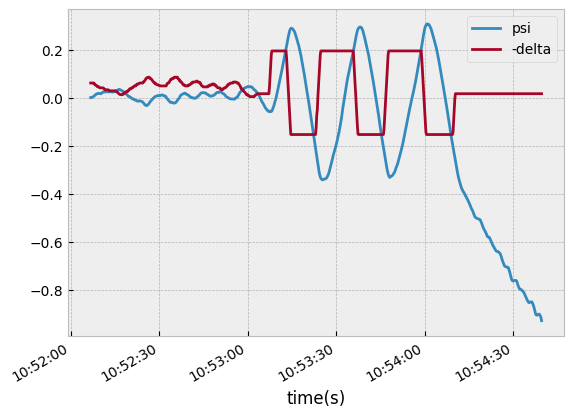

In [60]:
data_raw.plot(y=['psi','-delta'])

In [70]:
data_raw['trip_no'] = 0
plot_map(df=data_raw, time_step='1S', zoom_start=17, color_key='sog', colormap=['black', 'black'])